In [1]:
from parsimonious.grammar import Grammar
from parsimonious.nodes import NodeVisitor
from abc import ABC
import numpy as np 
from NameCreator import NameCreator
import networkx as nx
import matplotlib.pyplot as plt 

%matplotlib inline
grammar = Grammar(
     """
        expr = (term add expr) /  term
        term = (factor mul term) /  factor
        factor = (left expr right) / const 
        add = "+"
        mul = "*"
        left = "("
        right = ")"
        const = ~"[A-Z 0-9]*"i
     """)
tree = grammar.parse("d*(h+(g+k*(j+a))*i)+a*x")

In [2]:
class IniVisitor(NodeVisitor):
    def visit_expr(self, node, visited_children):
        """ Returns the overall output. """
        output = []
        for child in visited_children[0]:
            output.append(child)
        return output
    
    def visit_term(self, node, visited_children):
        """ Gets each key/value pair, returns a tuple. """
        return visited_children[0]

    def visit_factor(self, node, visited_children):
        """ Gets each key/value pair, returns a tuple. """
        return visited_children[0]
    
    def visit_const(self, node, visited_children):
        """ Gets each key/value pair, returns a tuple. """
        return node.text
    def visit_add(self, node, visited_children):
        """ Gets each key/value pair, returns a tuple. """
        return node.text
    def visit_mul(self, node, visited_children):
        """ Gets each key/value pair, returns a tuple. """
        return node.text

    def visit_left(self, node, visited_children):
        """ Gets each key/value pair, returns a tuple. """
        return node.text
    
    def visit_right(self, node, visited_children):
        """ Gets each key/value pair, returns a tuple. """
        return node.text

    def generic_visit(self, node, visited_children):
        """ The generic visit method. """
        return visited_children or node

In [3]:
iv = IniVisitor()
output = iv.visit(tree)
print(output)

[['d', '*', ['(', ['h', '+', [['(', ['g', '+', ['k', '*', ['(', ['j', '+', ['a']], ')']]], ')'], '*', 'i']], ')']], '+', ['a', '*', 'x']]


In [4]:
class Tensor(ABC):
    def calculation(self):
        #Compute the value of current node
        pass

    def accept(self,visitor,ctx):
        visitor.visit(self,ctx)

class Expression(Tensor):
    def __init__(self,lhs:Tensor,op:str,rhs:Tensor,name=None):
        self.lhs = lhs
        self.rhs = rhs
        self.op = op
        self.value = self.calculation()
        self.grad = 0
        self.name = name if name else NameCreator.getName()
        
    def calculation(self):
        if self.op == '+':
            return self.lhs.calculation() + self.rhs.calculation()
        else:
            return self.lhs.calculation() * self.rhs.calculation()

    def accept(self,visitor,ctx):
        visitor.visit_Expression(self,ctx)

    def __str__(self,level=0):
        return self.get_str()

    def get_str(self,level=0):
        return '\n'+'\t'*level+"<var: "+self.name+ " grad:"+str(self.grad)+" value:"+str(self.value)+">"+\
                self.lhs.get_str(level+1)+\
                '\n'+'\t'*(level+1)+ '<'+str(self.op)+'/>'+\
                self.rhs.get_str(level+1)+\
                '\n'+'\t'*level+"</>"
    
class Variable(Tensor):
    def __init__(self,name:str,value:float=0):
        self.name = name
        self.value = np.random.randint(1,10,1)[0]
        self.grad = 0
        
    def calculation(self):
        return self.value
    
    def accept(self,visitor,ctx):
        visitor.visit_Variable(self,ctx)
    
    def get_str(self,level=0):
        return '\n'+'\t'*level+"<"+'var:'+ self.name + " value:"+str(self.value)+ ' grad:' +str(self.grad)+"/>"
    
    def __str__(self,level=0):
        return self.get_str()

def create_binary_tree(output,lookup):
    """
    :param output: output of visitor
    :param lookup: dictionary map name -> Variable object
    """
    if type(output) is str:
        if output in lookup:
            instance = lookup[output]
            if not isinstance(instance,Expression):
                return instance
            return Expression(create_binary_tree(instance.lhs.name,lookup),
                        instance.op,
                        create_binary_tree(instance.rhs.name,lookup),output)
        else:
            tmp = Variable(output)
            lookup[output] = tmp
            return tmp

    # 
    if len(output) == 1:
        if output[0] in lookup:
            instance = lookup[output[0]]
            if not isinstance(instance,Expression):
                return instance
            return Expression(create_binary_tree(instance.lhs.name,lookup),
                        instance.op,
                        create_binary_tree(instance.rhs.name,lookup),output[0])
        else:
            tmp = Variable(output[0])
            lookup[output[0]] = tmp
            return tmp
    else:
        # parenthesis => calculate the expression inside it
        if output[0] == '(':
            return create_binary_tree(output[1],lookup)
        # recursive construct tree
        return Expression(create_binary_tree(output[0],lookup),
                        output[1],
                        create_binary_tree(output[2],lookup))

In [5]:
NameCreator.resetCounter()
lookup = dict()
lookup['b'] = Variable('b',5)
lookup['c'] = Variable('c',7)
lookup['a'] = Expression(lookup['b'],'*',lookup['c'],'a')

tree = create_binary_tree(output,lookup)

In [6]:
print(str(tree))


<var: @temp_7 grad:0 value:6370>
	<var: @temp_5 grad:0 value:6190>
		<var:d value:5 grad:0/>
		<*/>
		<var: @temp_4 grad:0 value:1238>
			<var:h value:5 grad:0/>
			<+/>
			<var: @temp_3 grad:0 value:1233>
				<var: @temp_2 grad:0 value:137>
					<var:g value:1 grad:0/>
					<+/>
					<var: @temp_1 grad:0 value:136>
						<var:k value:4 grad:0/>
						<*/>
						<var: @temp_0 grad:0 value:34>
							<var:j value:4 grad:0/>
							<+/>
							<var: a grad:0 value:30>
								<var:b value:5 grad:0/>
								<*/>
								<var:c value:6 grad:0/>
							</>
						</>
					</>
				</>
				<*/>
				<var:i value:9 grad:0/>
			</>
		</>
	</>
	<+/>
	<var: @temp_6 grad:0 value:180>
		<var: a grad:0 value:30>
			<var:b value:5 grad:0/>
			<*/>
			<var:c value:6 grad:0/>
		</>
		<*/>
		<var:x value:6 grad:0/>
	</>
</>


In [7]:
class BackwardVisitor():
    def visit(self,node,ctx):
        node.accept(self,ctx)

    def calc_grad(self,node,ctx):
        op = ctx['op']
        prev_grad = ctx['grad']
        co_value = ctx['value']

        if op == '+':
            node.grad += prev_grad
        else:
            node.grad += prev_grad*co_value

    def visit_Expression(self,node,ctx):
        self.calc_grad(node,ctx)
        ctx_lhs = {'grad':node.grad,'op':node.op,'value':node.rhs.value}
        ctx_rhs = {'grad':node.grad,'op':node.op,'value':node.lhs.value}
        self.visit(node.lhs,ctx_lhs)
        self.visit(node.rhs,ctx_rhs)
    
    def visit_Variable(self,node,ctx):
        self.calc_grad(node,ctx)

In [8]:
v = BackwardVisitor()
ctx = {'grad':1,'op':'+','value':0}
v.visit(tree,ctx)

In [9]:
print(str(tree))


<var: @temp_7 grad:1 value:6370>
	<var: @temp_5 grad:1 value:6190>
		<var:d value:5 grad:1238/>
		<*/>
		<var: @temp_4 grad:5 value:1238>
			<var:h value:5 grad:5/>
			<+/>
			<var: @temp_3 grad:5 value:1233>
				<var: @temp_2 grad:45 value:137>
					<var:g value:1 grad:45/>
					<+/>
					<var: @temp_1 grad:45 value:136>
						<var:k value:4 grad:1530/>
						<*/>
						<var: @temp_0 grad:180 value:34>
							<var:j value:4 grad:180/>
							<+/>
							<var: a grad:180 value:30>
								<var:b value:5 grad:1116/>
								<*/>
								<var:c value:6 grad:930/>
							</>
						</>
					</>
				</>
				<*/>
				<var:i value:9 grad:685/>
			</>
		</>
	</>
	<+/>
	<var: @temp_6 grad:1 value:180>
		<var: a grad:6 value:30>
			<var:b value:5 grad:1116/>
			<*/>
			<var:c value:6 grad:930/>
		</>
		<*/>
		<var:x value:6 grad:30/>
	</>
</>


In [10]:
def find_edges(head):
    ret = []
    if isinstance(head,Variable):
        return ret
    else:
        left_edges = find_edges(head.lhs)
        right_edges = find_edges(head.rhs)
        ret = ret + left_edges + right_edges
        ret.append((head.lhs.name,head.name))
        ret.append((head.rhs.name,head.name))
        return ret

def find_nodes(head):
    ret = dict()
    if isinstance(head,Variable):
        ret[head.name] = 'var'
        return ret
    else:
        left_nodes = find_nodes(head.lhs)
        right_nodes = find_nodes(head.rhs)
        ret.update(left_nodes)
        ret.update(right_nodes)
        ret[head.name] = 'add' if head.op == '+' else 'mul'
        return ret

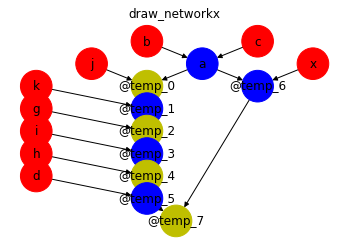

In [11]:
e = find_edges(tree)
v = find_nodes(tree)
colormap = list()
for k in v:
    if v[k] == 'var':
        colormap.append('r')
    elif v[k] == 'add':
        colormap.append('y')
    else:
        colormap.append('b')
v = list(v)

e.reverse()
G = nx.DiGraph()

G.add_nodes_from(v)
G.add_edges_from(e)

plt.title('draw_networkx')
pos=nx.drawing.nx_agraph.graphviz_layout(G, prog='dot',args='-Nfontsize=10 -Nwidth="10" -Nheight="1" -Nmargin=0 -Gfontsize=8')
nx.draw(G, pos, with_labels=True, arrows=True,node_size=1000,node_color=colormap)
plt.show()

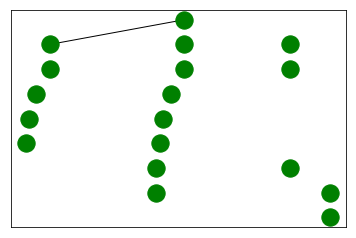

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig = plt.figure()

G = nx.Graph()
G.add_edges_from(e)
G.add_nodes_from(v)

pos=nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
edges = nx.draw_networkx_edges(G, pos, edge_color = 'w',with_labels=True)
nodes = nx.draw_networkx_nodes(G, pos, node_color = 'g',with_labels=True)

white = (1,1,1,1)
black = (0,0,0,1)

colors = [white for edge in edges.get_segments()]

def update(n):
    global colors

    try:
        idx = colors.index(white)
        colors[idx] = black
    except ValueError:
        colors = [white for edge in edges.get_segments()]

    edges.set_color(colors)
    return edges, nodes

anim = FuncAnimation(fig, update, interval=150, blit = True) 

plt.show()

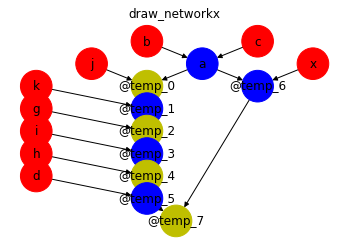

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

e.reverse()
G = nx.DiGraph()

G.add_nodes_from(v)
G.add_edges_from(e)

plt.title('draw_networkx')
pos=nx.drawing.nx_agraph.graphviz_layout(G, prog='dot',args='-Nfontsize=10 -Nwidth="10" -Nheight="1" -Nmargin=0 -Gfontsize=8')
nx.draw(G, pos, with_labels=True, arrows=True,node_size=1000,node_color=colormap)
plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
x = np.random.rand(15)
y = np.random.rand(15)
names = np.array(list("ABCDEFGHIJKLMNO"))
c = np.random.randint(1,5,size=15)
norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn
fig,ax = plt.subplots()
sc = plt.scatter(x,y,c=c, s=100, cmap=cmap, norm=norm)
annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)
def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
fig.canvas.mpl_connect("motion_notify_event", hover)
plt.show()

<Figure size 640x480 with 1 Axes>